In [1]:
# Libraries

# Python

from random import shuffle
import pandas as pd
import numpy as np
import sys
import json

# Machine Learning

import tensorflow as tf
from tensorflow import keras
from keras import initializers
from keras.layers import Dense
from keras.models import Sequential
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Data / Plotting

import matplotlib.pyplot as plt
import pymatgen as pymat
import mendeleev as mendel

%matplotlib inline

Using TensorFlow backend.


In [10]:
# Load in the data
raw_df = np.loadtxt(open("df_no_duplicates_clean_2.0.csv", "r"), delimiter = ',', dtype = str, skiprows = 0)

# Get the labels
df_labels = raw_df[0,1:]

# Make the dataframe
df = pd.DataFrame(raw_df[1:,1:], columns = df_labels)

# Convert to numeric values
new_df = df.iloc[:,1:].copy().apply(pd.to_numeric)

data = new_df.copy()

print(np.shape(df))
print(type(data.iloc[1,1]))

new_df.head()

(626, 30)
<class 'numpy.float64'>


,avg_hardness,avg_yield,Al,B,C,Cr,Cu,Fe,Mn,Mo,...,melting_point,specific_heat,atomic_mass,CTE,electrical_resistivity,atomic_radius,density_of_solid,poissons_ratio,electronegativity,max_min_radius
0,114.0,415.0,0.0,0.0,0.0,17.0,0.0,67.0499,0.0,0.0,...,1712.442192,0.415431,50.978826,0.000010,9.439990e-08,1.284699,7205.949126,0.254945,1.662013,0.05
1,114.0,415.0,0.0,0.0,0.0,17.0,0.0,67.5899,0.0,0.0,...,1722.205392,0.417823,51.280389,0.000010,9.493990e-08,1.292259,7248.468726,0.256511,1.671895,0.05
2,85.0,275.0,0.0,0.0,0.0,22.0,0.0,57.8449,0.0,0.0,...,1721.555792,0.416773,50.785834,0.000010,9.442490e-08,1.279829,7194.467426,0.251150,1.652962,0.05
3,254.0,310.0,0.0,0.0,0.2,0.0,0.0,98.1749,0.7,0.2,...,1801.565692,0.441232,55.468369,0.000012,1.628365e-06,1.390199,7811.170626,0.285327,1.819721,0.75
4,107.5,415.0,0.0,0.0,0.6,16.0,0.0,78.4299,0.0,0.0,...,1781.732592,0.429790,52.190618,0.000010,1.587499e-07,1.326219,7331.572326,0.261047,1.716167,0.70


In [4]:
# Create an 18x18 data frame that displays all the correlation coefficients between the inputs
pcorr = data.corr(method = 'pearson')
# All values will be between -1 (a negative line implying a 1:1 relationship) and +1 (positive line with 1:1 relationship)
# The center diagonal will have all +1 correlations since every variable is correlated with itself
# The closer the absolute value is to 1, the more correlated the variables are

pcorr.head()

,avg_hardness,avg_yield,Al,B,C,Cr,Cu,Fe,Mn,Mo,...,melting_point,specific_heat,atomic_mass,CTE,electrical_resistivity,atomic_radius,density_of_solid,poissons_ratio,electronegativity,max_min_radius
avg_hardness,1.000000,0.523801,0.059285,0.068926,0.072071,0.043012,0.114258,-0.086012,0.039332,0.128070,...,-0.030893,-0.059320,-0.037906,-0.046349,-0.051804,-0.065320,-0.044995,-0.063334,-0.044269,0.198794
avg_yield,0.523801,1.000000,0.086985,-0.074201,0.419049,-0.215744,0.216120,0.206088,0.026870,-0.012070,...,0.201554,0.217437,0.218537,0.219206,-0.044790,0.213411,0.209639,0.205774,0.233650,0.281416
Al,0.059285,0.086985,1.000000,-0.013329,-0.021699,0.072006,-0.021063,-0.092329,-0.047647,0.039386,...,-0.043463,0.009993,-0.068628,-0.058996,0.013567,-0.060949,-0.071116,-0.049636,-0.052137,-0.013671
B,0.068926,-0.074201,-0.013329,1.000000,-0.077776,0.122634,-0.015296,-0.158441,-0.042310,-0.041265,...,-0.138313,-0.085482,-0.188041,-0.134482,-0.017091,-0.173432,-0.161288,-0.147132,-0.145734,0.018752
C,0.072071,0.419049,-0.021699,-0.077776,1.000000,-0.543589,-0.121507,0.534274,0.075666,-0.238101,...,0.491134,0.593333,0.523899,0.566294,0.057965,0.547490,0.540243,0.517032,0.590833,0.568684


In [6]:
p = pcorr.values
print(type(p))
labels = pcorr.columns.to_list()
print(labels)

<class 'numpy.ndarray'>
['avg_hardness', 'avg_yield', 'Al', 'B', 'C', 'Cr', 'Cu', 'Fe', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'S', 'Si', 'Ti', 'V', 'youngs_modulus', 'lattice_constant', 'melting_point', 'specific_heat', 'atomic_mass', 'CTE', 'electrical_resistivity', 'atomic_radius', 'density_of_solid', 'poissons_ratio', 'electronegativity', 'max_min_radius']


AxesImage(135,135;837x815.4)


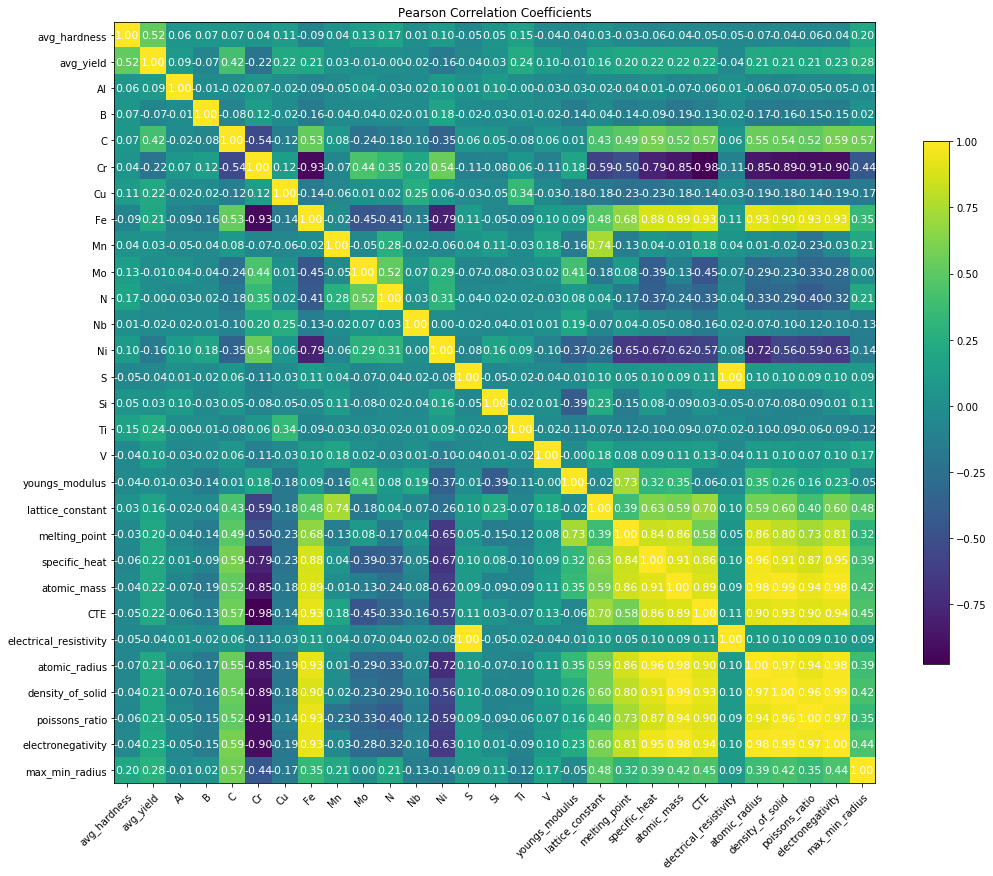

In [8]:
fig, ax = plt.subplots(figsize = [15,15])
im = ax.imshow(p)
print(im)

# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for y in range(p.shape[0]):
    for x in range(p.shape[1]):
        plt.text(x, y, '%.2f' % p[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = "w",
                fontsize = 11)

ax.set_title("Pearson Correlation Coefficients")
cbar = plt.colorbar(im, shrink = 0.5)
fig.tight_layout()
plt.show()